# [Robust Bayesian Regression](https://storopoli.io/Bayesian-Julia/pages/10_robust_reg)

Leaving the universe of linear models, we start to venture into generalized linear models (GLM). The fourth of these is `robust regression`.

A regression with count data behaves exactly like a linear model: it makes a prediction simply by computing a weighted sum of the independent variables `X` by the estimated coefficients `β`, plus an intercept `α`. However, instead of using a Gaussian/normal likelihood function, it uses a `Student`-t` likelihood function`.

We use robust regression in the same context as linear regression: our dependent variable is continuous. But robust regression allows us to better handle outliers in our data.

Before we dive in the nuts and bolts of robust regression let's remember the Gaussian/normal curve that has a bell shape (figure below). It does not have a "fat tail" (or sometimes known as "long tail"). In other words, the observations are not far from the mean. When we use this distribution as a likelihood function in the Bayesian models, we force that all estimates must be conditioned into a normal distribution of the dependent variable. If there are many outliers in the data (observations quite far from the mean), this causes the estimates of the independent variables' coefficients to be unstable. This is because the normal distribution cannot contemplate observations that are very spread away from the mean without having to change the mean's position (or location). In other words, the bell curve needs to "shift" to be able to contemplate outliers, thus making the inference unstable.

In [1]:
using CairoMakie
using Distributions

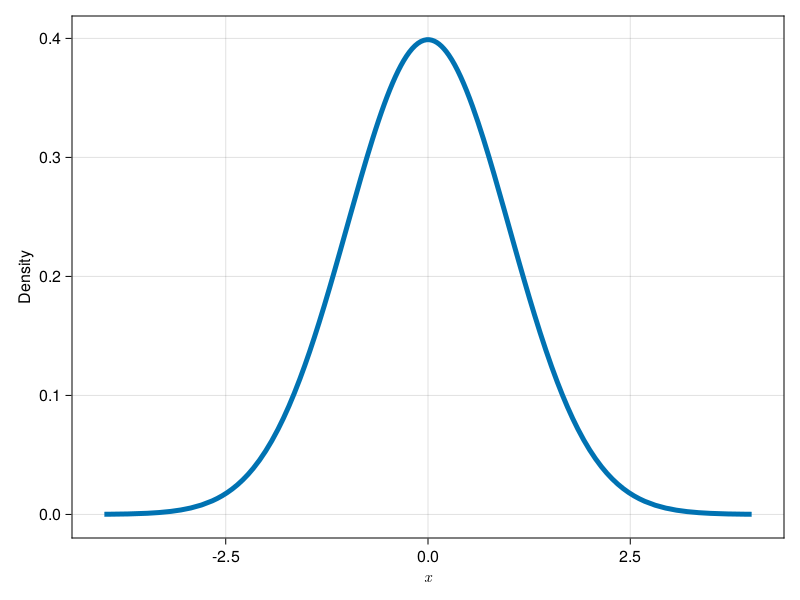

In [2]:
f, ax, l = lines(-4 .. 4, Normal(0, 1); linewidth=5, axis=(; xlabel=L"x", ylabel="Density"))

$$
\text{ Normal with } μ = 0 \text{ and } σ = 1
$$


So we need a more "malleable" distribution as a likelihood function. A distribution that is more robust to outliers. A distribution similar to Normal but that has "fatter" (or "longer") tails to precisely contemplate observations very far from the average without having to "shift" the mean's position (or location). For that we have the Student-t distribution. See the figure below to remember its shape.

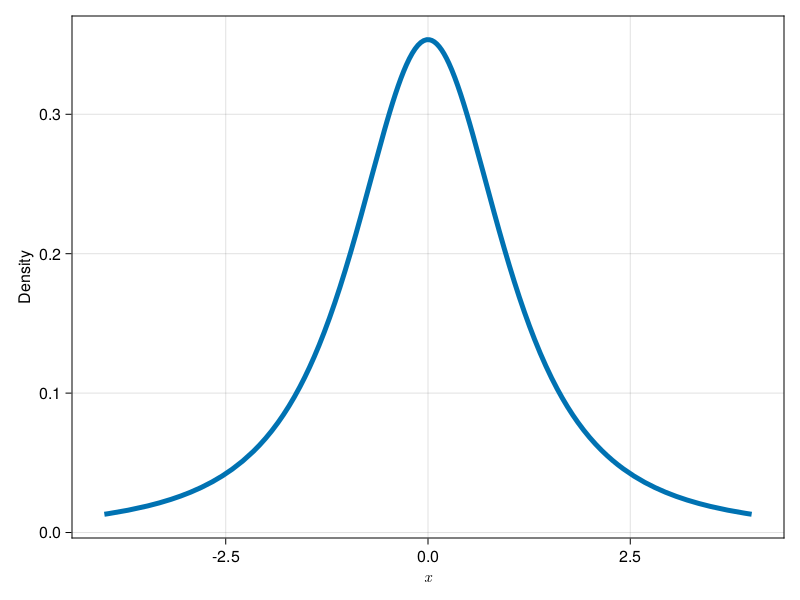

In [6]:
f, ax, l = lines(-4 .. 4, TDist(2); linewidth=5, axis=(xlabel=L"x", ylabel="Density"))


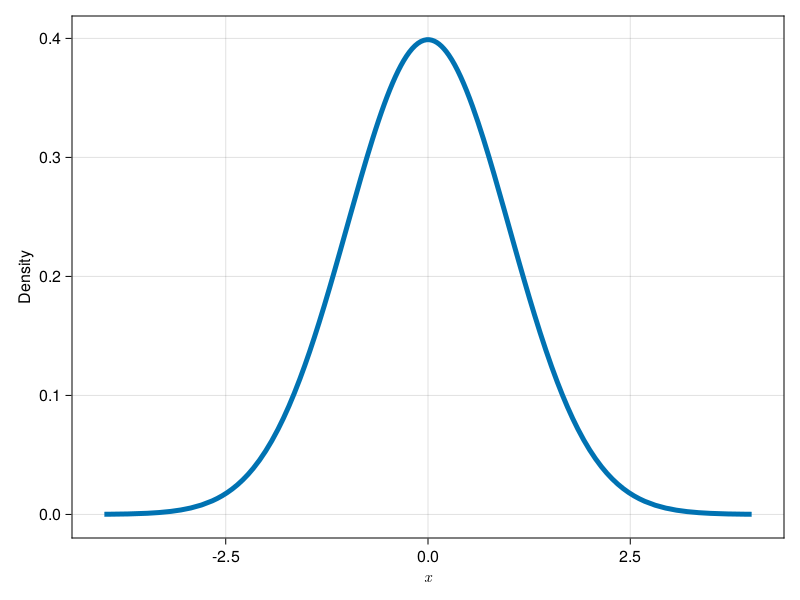

In [8]:
f, ax, l = lines(
    -4 .. 4,
    Normal(0, 1);
    linewidth=5,
    label="Normal",
    axis=(; xlabel=L"x", ylabel="Density"),
)
# lines!(ax, -4 .. 4, TDist(2); linewidth=5, label="Student")
# axislegend(ax)

In [9]:
using Turing
using Statistics: mean, std
using StatsBase: mad
using Random: seed!
seed!(123)

@model function robustreg(X, y; predictors=size(X, 2))
    #priors
    α ~ LocationScale(median(y), 2.5 * mad(y), TDist(3))
    β ~ filldist(TDist(3), predictors)
    σ ~ Exponential(1)
    ν ~ LogNormal(2, 1)

    #likelihood
    return y ~ arraydist(LocationScale.(α .+ X * β, σ, TDist.(ν)))
end;

In [10]:
using DataFrames
using CSV
using HTTP

url = "https://raw.githubusercontent.com/storopoli/Bayesian-Julia/master/datasets/duncan.csv"
duncan = CSV.read(HTTP.get(url).body, DataFrame)
describe(duncan)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,profession,,RR.engineer,,welfare.worker,0,String31
2,type,,bc,,wc,0,String7
3,income,41.8667,7,42.0,81,0,Int64
4,education,52.5556,7,45.0,100,0,Int64
5,prestige,47.6889,3,41.0,97,0,Int64


In [15]:
f = Figure()
plt = data(duncan) * mapping(:prestige) * AlgebraOfGraphics.density()
draw!(f[1, 1], plt)

LoadError: UndefVarError: `mapping` not defined

In [12]:
X = Matrix(select(duncan, [:income, :education]))
y = duncan[:, :prestige]
model = robustreg(X, y);

In [13]:
chain = sample(model, NUTS(), MCMCThreads(), 1_000, 4)
summarystats(chain)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC ~/.julia/packages/AbstractMCMC/fWWW0/src/sample.jl:296
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.025
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.025
Sampling (1 threads): 100%|█████████████████████████████| Time: 0:00:01


Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           α   -7.4614    3.0519    0.0616   2463.9986   1949.3300    0.9998   ⋯
        β[1]    0.7699    0.1061    0.0026   1655.6864   1773.0005    1.0064   ⋯
        β[2]    0.4452    0.0842    0.0021   1711.6471   1495.3930    1.0029   ⋯
           σ    7.3121    1.7937    0.0490   1304.6819   1363.9236    1.0012   ⋯
           ν    3.1732    3.8754    0.1073   1480.2541   1492.0843    1.0005   ⋯
                                                                1 column omitted


In [14]:
quantile(chain)

Quantiles
  parameters       2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol    Float64   Float64   Float64   Float64   Float64 

           α   -13.4314   -9.3873   -7.4755   -5.5327   -1.3232
        β[1]     0.5406    0.7057    0.7731    0.8397    0.9724
        β[2]     0.2816    0.3912    0.4434    0.4983    0.6177
           σ     4.2604    5.9988    7.1275    8.4590   11.1695
           ν     1.0230    1.6409    2.2648    3.3568   11.6459
